### Spark notebook ###

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

**Steps**

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

## Start Spark 

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)

spark.app.name,kda115 (jupyter)
spark.dynamicAllocation.enabled,false
spark.app.startTime,1724283017000
spark.master,spark://masternode2:7077
spark.app.id,app-20240822113018-0957
spark.executor.id,driver
spark.driver.memory,1g
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.executor.memory,1g
spark.rdd.compress,True
spark.executor.instances,2


## Processing 

## Question 01 

### a. How is data structured?

In [3]:
# List all files and directories in the HDFS 
! hdfs dfs -ls hdfs:///data/ghcnd

Found 5 items
drwxr-xr-x   - jsw93 jsw93          0 2024-08-21 12:34 hdfs:///data/ghcnd/daily
-rw-r--r--   8 jsw93 jsw93       3659 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-countries.txt
-rw-r--r--   8 jsw93 jsw93   34791732 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-inventory.txt
-rw-r--r--   8 jsw93 jsw93       1086 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-states.txt
-rw-r--r--   8 jsw93 jsw93   11007484 2024-08-13 14:44 hdfs:///data/ghcnd/ghcnd-stations.txt


### b. How many years are contained daily, and how does the size of the data change?

#### b.1 How many years are contained daily 

In [4]:
# List the files in the daily directory to identify years
! hdfs dfs -ls hdfs:///data/ghcnd/daily/ 

Found 263 items
-rw-r--r--   8 jsw93 jsw93    1897634 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1750.csv.gz
-rw-r--r--   8 jsw93 jsw93       3358 2024-08-07 01:44 hdfs:///data/ghcnd/daily/1763.csv.gz
-rw-r--r--   8 jsw93 jsw93       3327 2024-08-07 01:42 hdfs:///data/ghcnd/daily/1764.csv.gz
-rw-r--r--   8 jsw93 jsw93       3335 2024-08-07 01:41 hdfs:///data/ghcnd/daily/1765.csv.gz
-rw-r--r--   8 jsw93 jsw93       3344 2024-08-07 01:38 hdfs:///data/ghcnd/daily/1766.csv.gz
-rw-r--r--   8 jsw93 jsw93       3356 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1767.csv.gz
-rw-r--r--   8 jsw93 jsw93       3325 2024-08-07 01:41 hdfs:///data/ghcnd/daily/1768.csv.gz
-rw-r--r--   8 jsw93 jsw93       3418 2024-08-07 01:41 hdfs:///data/ghcnd/daily/1769.csv.gz
-rw-r--r--   8 jsw93 jsw93       3357 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1770.csv.gz
-rw-r--r--   8 jsw93 jsw93       3373 2024-08-07 01:43 hdfs:///data/ghcnd/daily/1771.csv.gz
-rw-r--r--   8 jsw93 jsw93       3419 2024-08-07 01:42 hdfs:///d

In [5]:
# Get the disk usage of the daily directory 
! hdfs dfs -du -h hdfs:///data/ghcnd/daily/

1.8 M    14.5 M    hdfs:///data/ghcnd/daily/1750.csv.gz
3.3 K    26.2 K    hdfs:///data/ghcnd/daily/1763.csv.gz
3.2 K    26.0 K    hdfs:///data/ghcnd/daily/1764.csv.gz
3.3 K    26.1 K    hdfs:///data/ghcnd/daily/1765.csv.gz
3.3 K    26.1 K    hdfs:///data/ghcnd/daily/1766.csv.gz
3.3 K    26.2 K    hdfs:///data/ghcnd/daily/1767.csv.gz
3.2 K    26.0 K    hdfs:///data/ghcnd/daily/1768.csv.gz
3.3 K    26.7 K    hdfs:///data/ghcnd/daily/1769.csv.gz
3.3 K    26.2 K    hdfs:///data/ghcnd/daily/1770.csv.gz
3.3 K    26.4 K    hdfs:///data/ghcnd/daily/1771.csv.gz
3.3 K    26.7 K    hdfs:///data/ghcnd/daily/1772.csv.gz
3.3 K    26.3 K    hdfs:///data/ghcnd/daily/1773.csv.gz
3.3 K    26.5 K    hdfs:///data/ghcnd/daily/1774.csv.gz
6.2 K    49.7 K    hdfs:///data/ghcnd/daily/1775.csv.gz
6.3 K    50.2 K    hdfs:///data/ghcnd/daily/1776.csv.gz
6.3 K    50.2 K    hdfs:///data/ghcnd/daily/1777.csv.gz
6.1 K    48.8 K    hdfs:///data/ghcnd/daily/1778.csv.gz
6 K      48 K      hdfs:///data/ghcnd/daily/1779

In [6]:
# Count the number of files in daily folder 
! hdfs dfs -count hdfs:///data/ghcnd/daily 

           1          263        13348547980 hdfs:///data/ghcnd/daily


##### There 263 files in daily directory  from 1750 - 2024

#### b.2 How does the size of the data change?

In [8]:
# In order to interpret how the size change over years, we need to transform the data to csv and plot it 
# In this case, we only need to transfer the column 5 and column 8 for plotting 
# ! hdfs dfs -du -h hdfs:///data/ghcnd/daily | awk 'BEGIN {OFS=","} {print $1, $2, $3, $4, $5}' > daily_data.csv
! hdfs dfs -ls hdfs:///data/ghcnd/daily | awk 'BEGIN {OFS=","} {print $5, $8}' > daily_data_1.csv

In [2]:
# Load the dataset had just converted to CSV file 
import pandas as pd 
daily_data = pd.read_csv("daily_data_1.csv")

# Print several rows
daily_data.head()

,Size,File
0,1897634,hdfs:///data/ghcnd/daily/1750.csv.gz
1,3358,hdfs:///data/ghcnd/daily/1763.csv.gz
2,3327,hdfs:///data/ghcnd/daily/1764.csv.gz
3,3335,hdfs:///data/ghcnd/daily/1765.csv.gz
4,3344,hdfs:///data/ghcnd/daily/1766.csv.gz


In [3]:
import re 

# Write the function to extract the year from file column 
def extract_year(data):
    "Function to extract year from file path"
    match = re.search(r'/(\d{4})\.csv\.gz$', data)
    return int(match.group(1)) if match else None

# Apply the function to extract year
daily_data["Year"] = daily_data['File'].apply(extract_year)

# Print out the data after extract 
daily_data.head()

,Size,File,Year
0,1897634,hdfs:///data/ghcnd/daily/1750.csv.gz,1750
1,3358,hdfs:///data/ghcnd/daily/1763.csv.gz,1763
2,3327,hdfs:///data/ghcnd/daily/1764.csv.gz,1764
3,3335,hdfs:///data/ghcnd/daily/1765.csv.gz,1765
4,3344,hdfs:///data/ghcnd/daily/1766.csv.gz,1766


##### Plot the data to see how the size of data change over time 

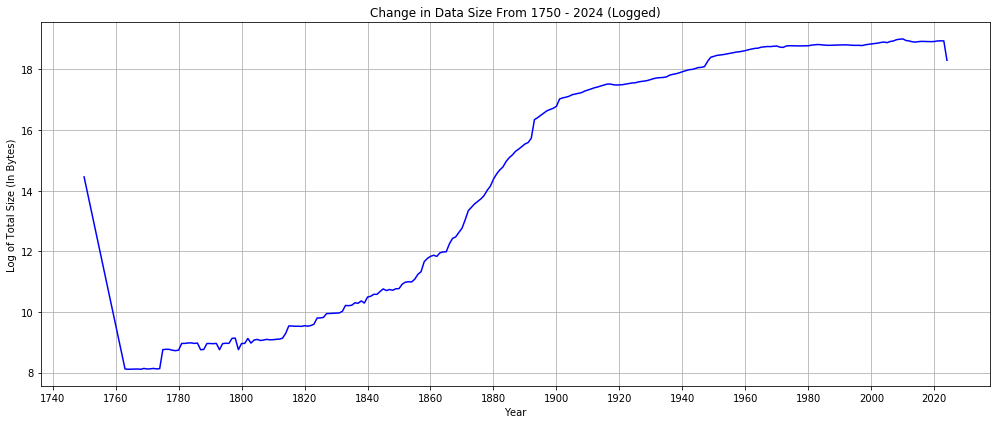

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Define your custom format function
def custom_format(value, tick_number):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(14, 6))

# Subplot: Logged Data
logged_size = np.log(daily_data['Size'])
plt.plot(daily_data['Year'], logged_size, linestyle='-', color='blue')
plt.title('Change in Data Size From 1750 - 2024 (Logged)')
plt.xlabel('Year')
plt.ylabel('Log of Total Size (In Bytes)')

# Set x-axis ticks with a step size of 20
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.grid(True)

#image_filename = 'Data_Size_Over_Years (Logged).png'
#plt.savefig(image_filename, format='png', dpi=300)  # Save as PNG with 300 DPI

# Show the plot
plt.tight_layout()
plt.show()

### Take the logged 

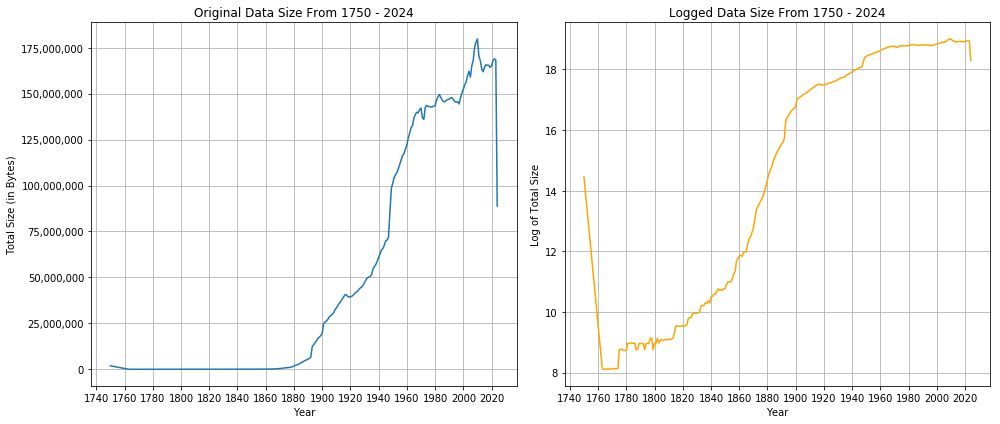

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Define your custom format function
def custom_format(value, tick_number):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(14, 6))

# Subplot 1: Original Data
plt.subplot(1, 2, 1)
plt.plot(daily_data['Year'], daily_data['Size'], linestyle='-')
plt.title('Original Data Size From 1750 - 2024')
plt.xlabel('Year')
plt.ylabel('Total Size (in Bytes)')

# Apply the custom formatter to the y-axis
ax1 = plt.gca()  # Get the current axis
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(custom_format))

# Set x-axis ticks with a step size of 20
ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.grid(True)

# Subplot 2: Logged Data
plt.subplot(1, 2, 2)
logged_size = np.log(daily_data['Size'])
plt.plot(daily_data['Year'], logged_size, linestyle='-', color='orange')
plt.title('Logged Data Size From 1750 - 2024')
plt.xlabel('Year')
plt.ylabel('Log of Total Size')

# Set x-axis ticks with a step size of 20
ax2 = plt.gca()  # Get the current axis
ax2.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

### c. What is the total size of all of the data, and how much of that is daily 

#### c.1 What is the total size of all of the data 

In [18]:
# using -du and -s provide a summary of disk usage for the entire directory 
! hdfs dfs -du -s -h hdfs:///data/ghcnd/

12.5 G  99.8 G  hdfs:///data/ghcnd


In [19]:
# Get the disk usage of the daily directory to compare 
! hdfs dfs -du -s -h hdfs:///data/ghcnd/daily

12.4 G  99.5 G  hdfs:///data/ghcnd/daily


In [50]:
# Get the disk usage of the entire ghcnd 
! hdfs dfs -du -h hdfs:///data/ghcnd/ 

12.4 G  99.5 G   hdfs:///data/ghcnd/daily
3.6 K   28.6 K   hdfs:///data/ghcnd/ghcnd-countries.txt
33.2 M  265.4 M  hdfs:///data/ghcnd/ghcnd-inventory.txt
1.1 K   8.5 K    hdfs:///data/ghcnd/ghcnd-states.txt
10.5 M  84.0 M   hdfs:///data/ghcnd/ghcnd-stations.txt


##### In order to summarize  the sizes of the datasets, we transform the disk usage data into the csv file 

In [48]:
# List the sizes of all directories/files in ghcnd and store it to a local csv
! hdfs dfs -du -h hdfs:///data/ghcnd/ | awk '{print $1, $2, $3, $4, $5}' > dataset_sizes.csv 

In [92]:
# Load the dataset that had just converted to csv 
dataset_sizes = pd.read_csv("dataset_sizes.csv")

# Print the data 
dataset_sizes.head()

,Actual_Size,Disk_Space_Usage,Datasets
0,12.4 G,99.5 G,Daily
1,3.6 K,28.6 K,Countries
2,33.2 M,265.4 M,Inventory
3,1.1 K,8.5 K,States
4,10.5 M,84.0 M,Stations


#### Since the dataset_sizes have several size unit such as: 
#### G : Gigabytes 
#### K : Kilobyte
#### M : Megabyte 
#### In order to have a consistent unit, we need to convert the size into a consistent unit 
#### Here, we will convert the actual size into Kilobyte(KB)

In [93]:
# Write the function to convert the size to Kilobyte 
def convert_to_kb(size_str):
    "Write a function to convert the actual size to kilobyte"
    # Normalize the input 
    size_str = size_str.strip().upper()
    if size_str.endswith("B"):
        size = float(size_str[:-1].strip())
        return size / 1024 #convert bytes to kilobytes 
    elif size_str.endswith("K"):
        size = float(size_str[:-1].strip())
        return size # Already in kilobytes
    elif size_str.endswith("M"):
        size = float(size_str[:-1].strip())
        return size * 1024 # convert megabytes to kilobytes 
    elif size_str.endswith("G"):
        size = float(size_str[:-1].strip())
        return size * 1024 * 1024 # convert gigabytes to kilobytes 
    else:
        raise ValueError(f"Unknown size unit in '{size_str}'")
        
# Apply the function to the data 
dataset_sizes['Size_in_KB'] = dataset_sizes['Actual_Size'].apply(convert_to_kb)

# Print the dataset_sizes
dataset_sizes.head()

,Actual_Size,Disk_Space_Usage,Datasets,Size_in_KB
0,12.4 G,99.5 G,Daily,13002342.4
1,3.6 K,28.6 K,Countries,3.6
2,33.2 M,265.4 M,Inventory,33996.8
3,1.1 K,8.5 K,States,1.1
4,10.5 M,84.0 M,Stations,10752.0


#### c.2 How much of that is daily?
#####  To know how many percent of this is daily we need to calculate the proportion of the total size 
#####  Find the proportion for each dataset 

In [94]:
# Calculate the total size
total_size = dataset_sizes['Size_in_KB'].sum()

# Calculate the percentage of total size for each dataset 
dataset_sizes['Percentage_of_Total(%)'] = round((dataset_sizes['Size_in_KB'] / total_size) * 100,8)

# Print the dataset
dataset_sizes

,Actual_Size,Disk_Space_Usage,Datasets,Size_in_KB,Percentage_of_Total(%)
0,12.4 G,99.5 G,Daily,13002342.4,99.656985
1,3.6 K,28.6 K,Countries,3.6,0.000028
2,33.2 M,265.4 M,Inventory,33996.8,0.260570
3,1.1 K,8.5 K,States,1.1,0.000008
4,10.5 M,84.0 M,Stations,10752.0,0.082409


##### The daily data have a highest size in the dataset, which accounted for 99.65 % of all the datasets.

In [83]:
# Save the DataFrame to a CSV file
csv_filename = 'dataset_sizes_converted.csv'
dataset_sizes.to_csv(csv_filename, index=False)  # index=False to avoid writing row numbers

In [20]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()